# Data Processing Notebook
This notebook will process data collected by `deep_tube_learning/data_collection.py`, including visualizing some sample data and generating the default dataset for training tube dynamics or error dynamics, $$\mathcal{D} = \{z_t, P_z(x_t), v_t, z_{t+1}, P_z(x_{t+1})\}$$

In [13]:
import os
import glob
import wandb
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

First, load in the data. This will grab data from `wandb` if data is not currently downloaded locally (otherwise, it will use the local data).

In [14]:
run_id = "e95cykpp"

# Download data if it isn't held locally
if not os.path.exists(run_id):
    experiment = f"coleonguard-Georgia Institute of Technology/RoM_Tracking_Data/{run_id}_rom_tracking_data:latest"
    api = wandb.Api()
    artifact = api.artifact(experiment)
    data = artifact.download(root=Path(run_id))

# Combine epoch data into a single dataset
epoch_files = glob.glob(f"{run_id}/epoch_*.pickle")
z, v, x, u, done, pz_x, data_shape = None, None, None, None, None, None, None
robot_pose, robot_vel, des_pose, des_vel, des_vel_local, err_local, err_global = None, None, None, None, None, None, None
for epoch_file in epoch_files:
    with open(epoch_file, "rb") as f:
        epoch_data = pickle.load(f)
        
    # Reshape data to remove the 'num_robots' axis
    # Note that by removing N+1 element from z, Pz_x, all arrays now have same leading axis
    # Since the last element of leading axis always has done=True, removing 'num_robots' axis will not lead to spurious transition
    z_e = epoch_data['z'][:-1, :, :]
    data_shape = z_e.shape
    z_e = z_e.reshape((data_shape[0] * data_shape[1], -1), order='F')
    v_e = epoch_data['v'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    x_e = epoch_data['x'][:-1, :, :].reshape((data_shape[0] * data_shape[1], -1), order='F')
    u_e = epoch_data['u'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    robot_pose_e = epoch_data['robot_pose'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    robot_vel_e = epoch_data['robot_vel'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    des_pose_e = epoch_data['des_pose'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    des_vel_e = epoch_data['des_vel'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    des_vel_local_e = epoch_data['des_vel_local'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    err_local_e = epoch_data['err_local'].reshape((data_shape[0] * data_shape[1], -1), order='F')
    err_global_e = epoch_data['err_global'].reshape((data_shape[0] * data_shape[1], -1), order='F')

    done_e = epoch_data['done']
    done_e[-1, :] = True
    done_e = done_e.reshape((data_shape[0] * data_shape[1], -1), order='F')
    pz_x_e = epoch_data['pz_x'][:-1, :, :].reshape((data_shape[0] * data_shape[1], -1), order='F')
        
    # Concatenate with other data
    if z is None:
        z = z_e
        v = v_e
        x = x_e
        u = u_e
        done = done_e
        pz_x = pz_x_e
        robot_pose = robot_pose_e
        robot_vel = robot_vel_e
        des_pose = des_pose_e
        des_vel = des_vel_e
        des_vel_local = des_vel_local_e
        err_local = err_local_e
        err_global = err_global_e
    else:
        z = np.vstack((z, z_e))
        v = np.vstack((v, v_e))
        x = np.vstack((x, x_e))
        u = np.vstack((u, u_e))
        done = np.vstack((done, done_e))
        pz_x = np.vstack((pz_x, pz_x_e))
        robot_pose = np.vstack((robot_pose, robot_pose_e))
        robot_vel = np.vstack((robot_vel, robot_vel_e))
        des_pose = np.vstack((des_pose, des_pose_e))
        des_vel = np.vstack((des_vel, des_vel_e))
        des_vel_local = np.vstack((des_vel_local, des_vel_local_e))
        err_local = np.vstack((err_local, err_global_e))
        err_global = np.vstack((err_global, err_global_e))

# Translate arrays by one for next steps
z_p1 = z
z_p1[:-1, :] = z[1:, :]
pz_x_p1 = pz_x
pz_x_p1[:-1, :] = pz_x[1:, :]

# Remove 'done' transitions
done = np.squeeze(done)
z = z[np.logical_not(done), :]
v = v[np.logical_not(done), :]
pz_x = pz_x[np.logical_not(done), :]
z_p1 = z_p1[np.logical_not(done), :]
pz_x_p1 = pz_x_p1[np.logical_not(done), :]
robot_pose = robot_pose[np.logical_not(done), :]
robot_vel = robot_vel[np.logical_not(done), :]
des_pose = des_pose[np.logical_not(done), :]
des_vel = des_vel[np.logical_not(done), :]
des_vel_local = des_vel_local[np.logical_not(done), :]
err_local = err_local[np.logical_not(done), :]
err_global = err_global[np.logical_not(done), :]

# Save dataset
dataset = {
    'z': z,
    'pz_x': pz_x,
    'v': v,
    'z_p1': z_p1,
    'pz_x_p1': pz_x_p1,
}

with open(f"{run_id}/dataset.pickle", "wb") as f:
    pickle.dump(dataset, f)

Next, plot some sample data to examine performance of the planning/tracking models

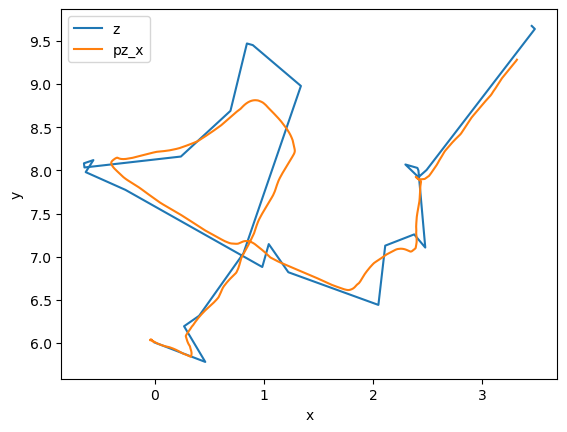

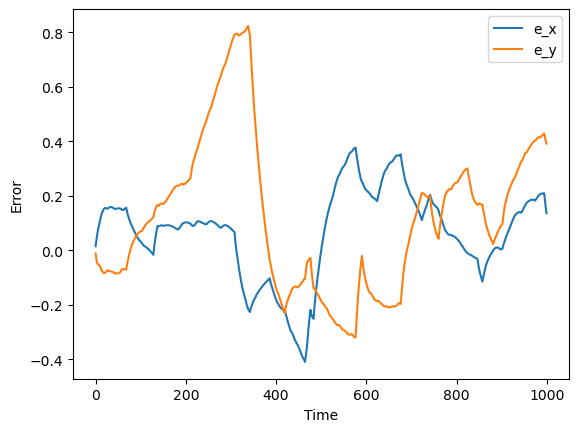

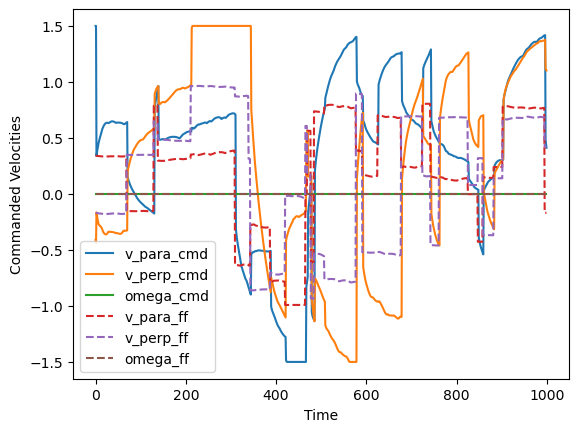

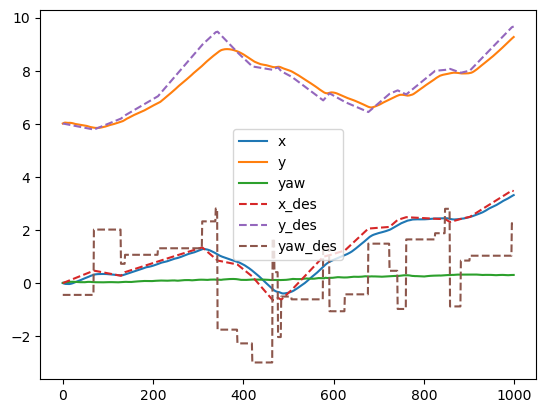

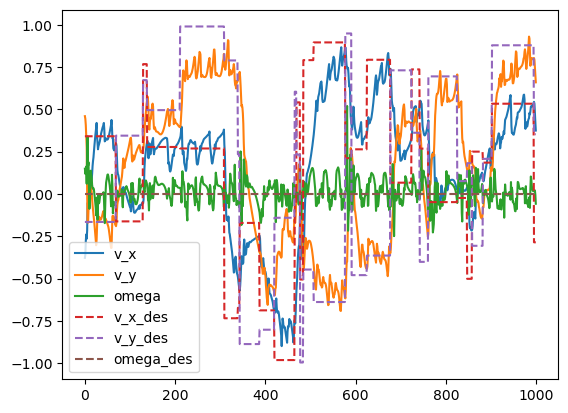

In [25]:
epoch = 0
robot = 2

N = data_shape[0] - 1
r = data_shape[1]

ind_0 = epoch * N * r + robot * N
ind_f = ind_0 + N
z_data = z[ind_0:ind_f, :]
v_data = v[ind_0:ind_f, :]
pz_x_data = pz_x[ind_0:ind_f, :]
u_data = u[ind_0:ind_f, :]

plt.figure()
plt.plot(z_data[:, 0], z_data[:, 1])
plt.plot(pz_x_data[:, 0], pz_x_data[:, 1])
plt.legend(['z', 'pz_x'])
plt.xlabel('x')
plt.ylabel('y')

plt.figure()
plt.plot(z_data[:, 0] - pz_x_data[:, 0])
plt.plot(z_data[:, 1] - pz_x_data[:, 1])
plt.legend(['e_x', 'e_y'])
plt.xlabel('Time')
plt.ylabel('Error')

plt.figure()
plt.plot(u_data)
plt.plot(des_vel_local[ind_0:ind_f, :], '--')
plt.legend(['v_para_cmd', 'v_perp_cmd', 'omega_cmd', 'v_para_ff', 'v_perp_ff', 'omega_ff'])
plt.xlabel('Time')
plt.ylabel('Commanded Velocities')

plt.figure()
plt.plot(robot_pose[ind_0:ind_f, :])
plt.plot(des_pose[ind_0:ind_f, :], '--')
plt.legend(['x', 'y', 'yaw', 'x_des', 'y_des', 'yaw_des'])

plt.figure()
plt.plot(robot_vel[ind_0:ind_f, :])
plt.plot(des_vel[ind_0:ind_f, :], '--')
plt.legend(['v_x', 'v_y', 'omega', 'v_x_des', 'v_y_des', 'omega_des'])

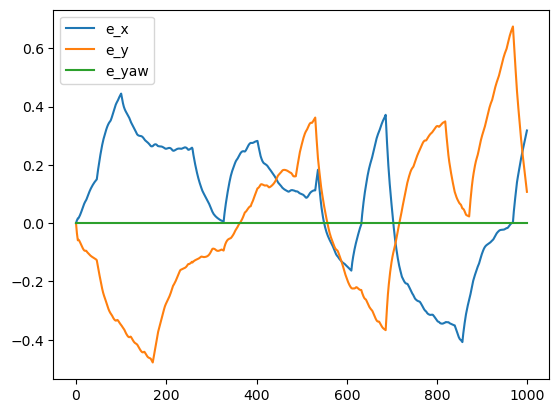

In [16]:
plt.figure()
plt.plot(err_global[ind_0:ind_f, :])
plt.legend(['e_x', 'e_y', 'e_yaw'])

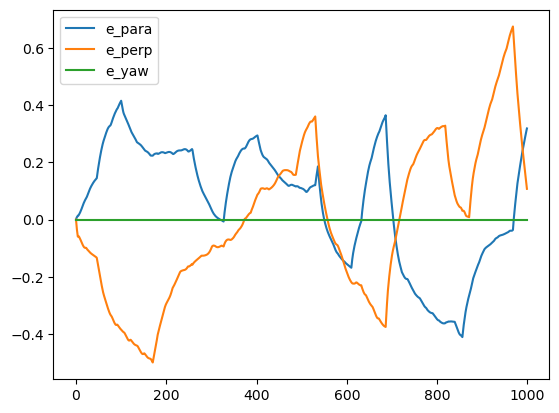

In [17]:
plt.figure()
plt.plot(err_local[ind_0:ind_f, :])
plt.legend(['e_para', 'e_perp', 'e_yaw'])

Text(0, 0.5, 'Commanded Velocities')

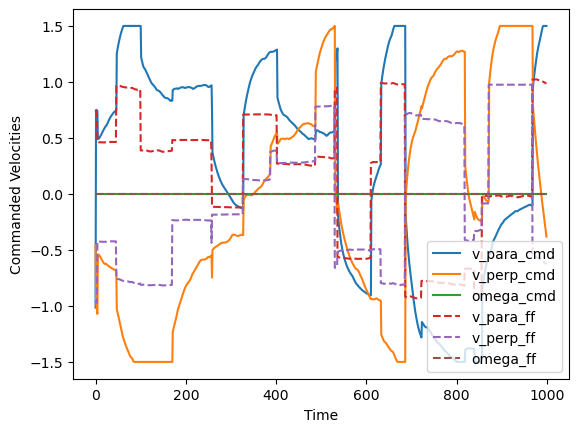

In [18]:
plt.figure()
plt.plot(u_data)
plt.plot(des_vel_local[ind_0:ind_f, :], '--')
plt.legend(['v_para_cmd', 'v_perp_cmd', 'omega_cmd', 'v_para_ff', 'v_perp_ff', 'omega_ff'])
plt.xlabel('Time')
plt.ylabel('Commanded Velocities')

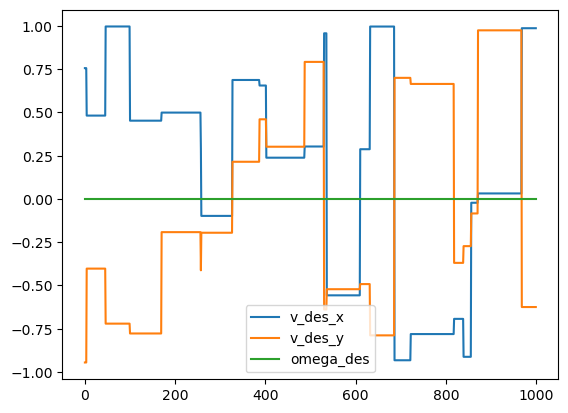

In [19]:
plt.figure()
plt.plot(des_vel[ind_0:ind_f, :])
plt.legend(['v_des_x', 'v_des_y', 'omega_des'])

In [20]:
z.shape

(21999, 2)

In [21]:
v.shape

(21999, 2)

In [22]:
u.shape

(22022, 3)

In [23]:
x.shape

(22022, 37)

In [24]:
pz_x.shape

(21999, 2)